In [1]:
# import dask.config as dc
import dask.array as da
import numpy as np
import rioxarray
import xarray as xr
import glob
from dask.distributed import Client, LocalCluster
from dask_jobqueue import SLURMCluster
import pandas as pd
from rasterio.warp import reproject, Resampling
import matplotlib.pyplot as plt

!!!
convert era5land from [0,360] to [-180,180], but do not clip it, resample SSM in [-180,180], then convert resampled SSM from [-180,180] to [0,360].

# SSM data: from NetCDF to Zarr

The Surface Soil moisture (SSM) dataset is provided as geotiff data. We reproject the spatial extend to match the ERA5 land dataset using rioxarray, which, unfortunately does not support Dask. It was reprojected and downloaded from GEE. It is only for Europe, need to download other area from GEE.

## Input variables

In [89]:
year = 2015

In [90]:
ROOT_DIR = '/gpfs/work2/0/ttse0619'
SSM_DIR = (
    f'{ROOT_DIR}/qianqian/global_data_Qianqian/'
    f'1input_data/{year}global/ssm/'
)
OUT_DIR = (
    f'{ROOT_DIR}/qianqian/global_data_Qianqian/'
    f'1input_data/{year}global/ssm'
)

In [91]:
ERA5_PATH = (
    f'{ROOT_DIR}/francesco/Projects/EcoExtreML/Data/'
    f'1input_data/{2015}global/era5land/era5land.zarr'
)

## Converting the dataset

We start by loading the ERA5-land Zarr dataset, which we will use as the target for reprojection: 

In [92]:
ds = xr.open_zarr(ERA5_PATH)

In [93]:
ds = ds.rio.write_crs('WGS84')
target = ds['sp'].isel(time=0, drop=True)

In [94]:
# convert from [0,360] to [-180,180]
target['longitude'] = (target['longitude'] + 180) % 360 - 180
target = target.sortby('longitude')

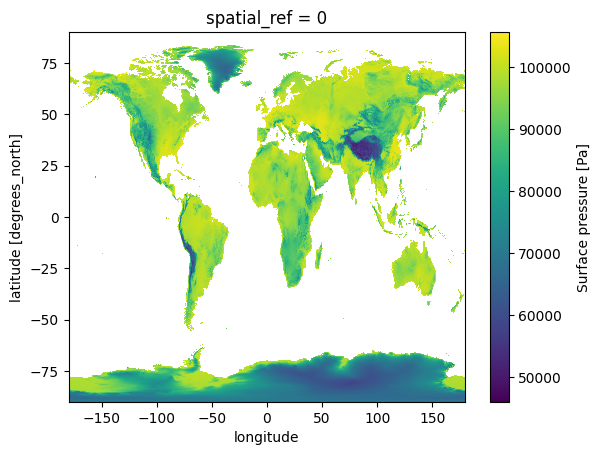

In [95]:
target.plot()

We now open the SSM geotiff files. NOTE: we do not set chunks in the spatial dimension because we need to load all values anyway to perform the reprojection. 

In [96]:
ssm_paths = sorted(
    glob.glob(f'{SSM_DIR}/*{year}*Europe*Europe*.tif')
)

In [97]:
ssm_paths

['/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2015global/ssm/SM2015Europe11kmEurope20230921.tif']

In [98]:
ssm = xr.open_dataset(ssm_paths[0])
ssm = ssm['band_data']
# ssm = ssm.sel(x=slice(20,25), y=slice(65, 60))

We fix the longitude ordering and make sure the CRS is in place:

In [99]:
ssm = ssm.rio.write_crs('WGS84')
ssm = ssm.rename(
    x='longitude',
    y='latitude',
)

We change band to time, and reproject!

In [100]:
ssm['band'] = pd.to_datetime(ssm.band-1, unit='D', origin=str(ssm_paths[0].split('/')[-1][2:6]))
ssm = ssm.rename({'band':'time'})
# ssm = ssm[0:2,:] # test for short periods

In [101]:
ssm.rio.write_nodata(np.nan, inplace=True)
ssm = ssm.rio.write_crs('EPSG:4326')
target = target.rio.write_crs('EPSG:4326')
# ssm.rio.write_nodata(ssm.rio.nodata, inplace=True)
ssm_reprojected = ssm.rio.reproject_match(target, resampling=Resampling.average, nodata=np.nan) #
ssm_reprojected = ssm_reprojected.rename(
    x='longitude',
    y='latitude',
)
ssm_reprojected.isnull().sum()

/home/qiahan/.local/lib/python3.9/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 20 entries) hit.
Flushing oldest 4 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


<xarray.DataArray 'band_data' ()>
array(2314666894)
Coordinates:
    spatial_ref  int64 0

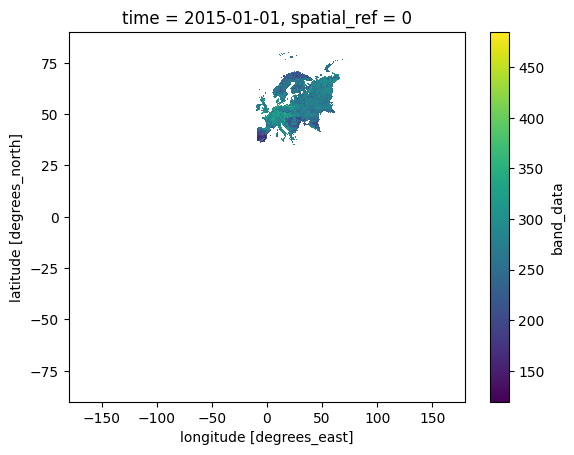

In [102]:
ssm_reprojected[0].plot()

In [103]:
ssm_reprojected = ssm_reprojected.assign_coords(
    longitude=(ssm_reprojected.longitude + 360) % 360,
    latitude=ssm_reprojected.latitude
)#.sortby('longitude')
# roll array to reorder coordinates 
nroll = (ssm_reprojected.longitude.values >= 180 ).sum()
ssm_reprojected = ssm_reprojected.roll(longitude=-nroll, roll_coords=True)

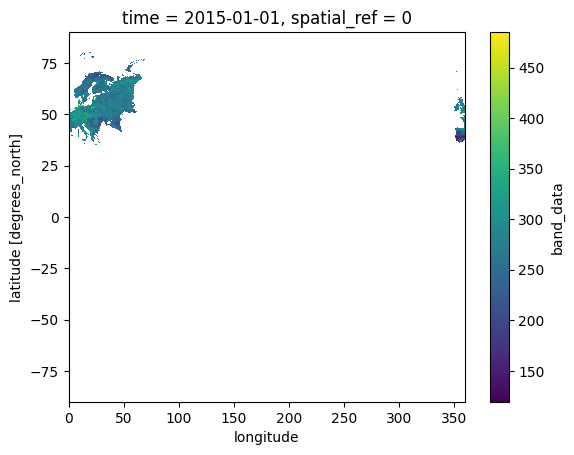

In [104]:
ssm_reprojected[0].plot()

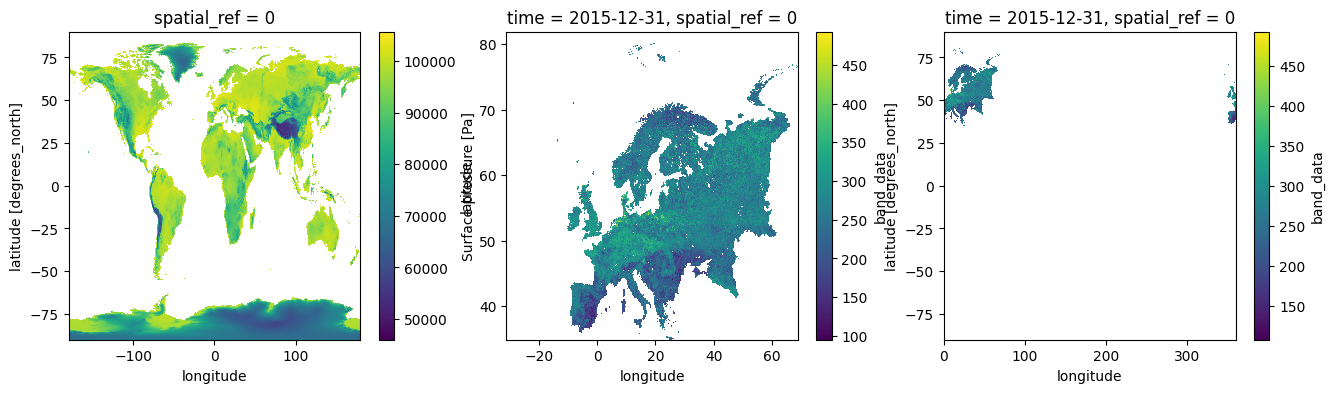

In [105]:
fig, axes = plt.subplots(ncols=3, figsize=(16,4))

target.plot(ax=axes[0])
ssm[-1,::].plot(ax=axes[1])
ssm_reprojected[-1,::].plot(ax=axes[2])
plt.draw()

We rechunk and save it as Zarr:

In [106]:
ssm_reprojected = ssm_reprojected.chunk(
    time=-1, 
    longitude=250, 
    latitude=250
)
ssm_reprojected = ssm_reprojected.to_dataset(name='SSM')

In [107]:
%%time
zarr_path = f'{OUT_DIR}/ssm.zarr'
ssm_reprojected.to_zarr(zarr_path, mode='w')

CPU times: user 18.9 s, sys: 5.79 s, total: 24.7 s
Wall time: 2.13 s


When done with the conversion we switch off the cluster to release resources:

In [108]:
!du -h $zarr_path

2.0K	/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2015global/ssm/ssm.zarr/spatial_ref
2.0K	/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2015global/ssm/ssm.zarr/longitude
2.0K	/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2015global/ssm/ssm.zarr/latitude
2.0K	/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2015global/ssm/ssm.zarr/time
17K	/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2015global/ssm/ssm.zarr/SSM
27K	/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2015global/ssm/ssm.zarr


/home/qiahan/.local/lib/python3.9/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 20 entries) hit.
Flushing oldest 4 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


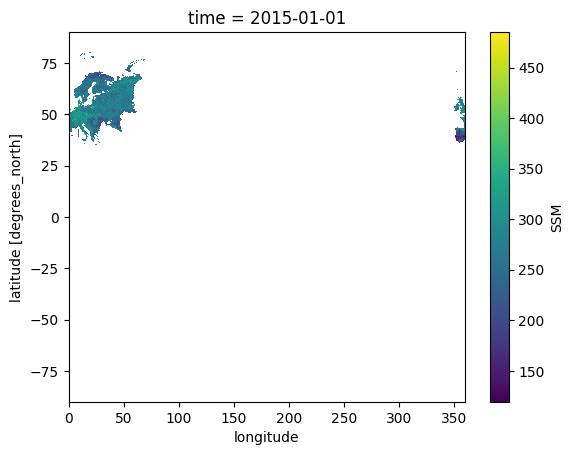

In [109]:
xr.open_zarr(zarr_path).SSM[0].plot()